In [1]:
# === 🧱 Imports ===
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.optimize import minimize

# === 🧹 Load and Preprocess Data ===
df = pd.read_csv("poisoned_proper_df.csv")
df["labels"] = df["model_family_vector"].apply(ast.literal_eval)
y = np.array(df["labels"].tolist())

# Combine text columns for TF-IDF input
df["combined_text"] = df["abstract_section"] + " " + df["section"]

# === 🧠 TF-IDF Vectorization ===
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), sublinear_tf=True)
X = tfidf.fit_transform(df["combined_text"])

# === ✂️ Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === ⚙️ Step 1: Train Base LinearSVC (One-vs-Rest) ===
base_svc = OneVsRestClassifier(LinearSVC(C=1.0, max_iter=10000))
base_svc.fit(X_train, y_train)

# === ⚙️ Step 2: Calibrate Per-Class with cv='prefit' ===
calibrated_estimators = []
for i in range(y_train.shape[1]):
    model_i = CalibratedClassifierCV(base_svc.estimators_[i], method='sigmoid', cv='prefit')
    model_i.fit(X_train, y_train[:, i])  # binary targets
    calibrated_estimators.append(model_i)

# === 🔮 Step 3: Predict Calibrated Probabilities ===
y_proba = np.column_stack([
    calibrated_estimators[i].predict_proba(X_test)[:, 1]
    for i in range(y_train.shape[1])
])

# === 🔧 Step 4: Joint Threshold Optimization ===
def optimize_all_thresholds(y_true, y_proba):
    n_classes = y_true.shape[1]

    def objective(thresholds):
        thresholds = np.clip(thresholds, 0.0, 1.0)
        y_pred = (y_proba >= thresholds).astype(int)
        f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        return -0.5 * (f1_micro + f1_macro)

    initial_thresholds = np.full(n_classes, 0.5)
    bounds = [(0.1, 0.9)] * n_classes

    result = minimize(objective, initial_thresholds, bounds=bounds, method='L-BFGS-B')
    best_thresholds = result.x
    best_score = -result.fun
    return best_thresholds, best_score

# === 🧪 Step 5: Run Optimization + Evaluate ===
best_thresholds, best_score = optimize_all_thresholds(y_test, y_proba)
y_pred_optimized = (y_proba >= best_thresholds).astype(int)

# === 📊 Final Report ===
print("=== TF-IDF + LinearSVC + Optimized Thresholds ===")
print(classification_report(y_test, y_pred_optimized))
print("F1 Micro:", f1_score(y_test, y_pred_optimized, average='micro'))
print("F1 Macro:", f1_score(y_test, y_pred_optimized, average='macro'))
print("Exact Match:", accuracy_score(y_test, y_pred_optimized))



/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

=== TF-IDF + LinearSVC + Optimized Thresholds ===
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        15
           1       1.00      0.14      0.25        14
           2       1.00      0.29      0.44         7
           3       0.80      0.27      0.40        15
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00        10
           7       1.00      0.19      0.32        16
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         5
          10       1.00      0.33      0.50         3
          11       0.83      0.31      0.45        16
          12       0.00      0.00      0.00         0
          13       0.62      0.24      0.34        21
          14       0.00      0.00      0.00         0
          15       0.88      0.41      0.56        17

   micro avg       0.84      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me


=== Threshold-Optimized Report ===
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        15
           1       1.00      0.14      0.25        14
           2       1.00      0.29      0.44         7
           3       0.80      0.27      0.40        15
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00        10
           7       1.00      0.19      0.32        16
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         5
          10       1.00      0.33      0.50         3
          11       0.83      0.31      0.45        16
          12       0.00      0.00      0.00         0
          13       0.62      0.24      0.34        21
          14       0.00      0.00      0.00         0
          15       0.88      0.41      0.56        17

   micro avg       0.84      0.21      0.34 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

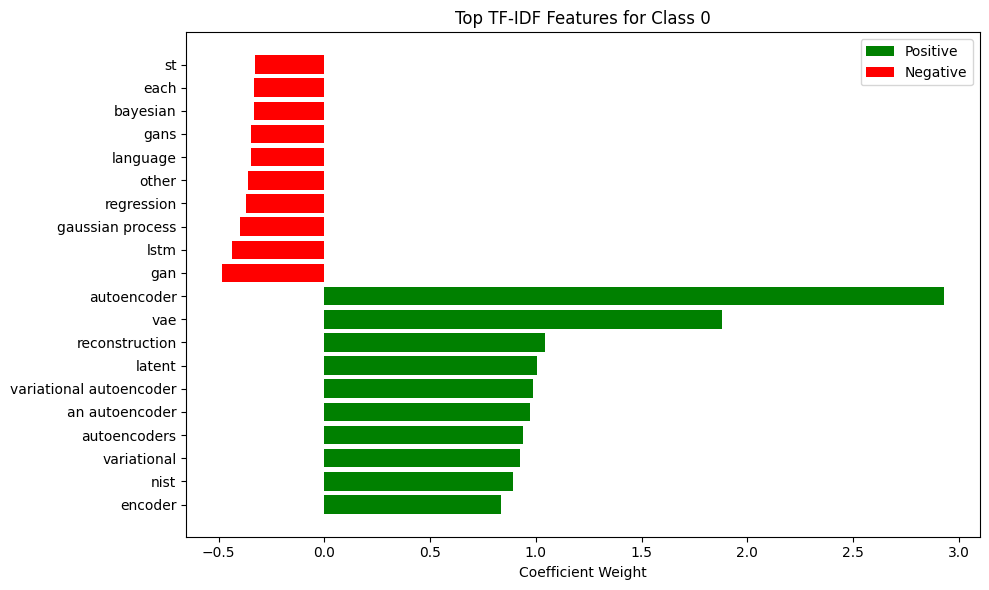

In [2]:
def plot_top_tfidf_features(class_index, top_n=10):
    """
    Plots the top TF-IDF features with highest absolute weight for the given class.
    """
    # Get the vocabulary
    feature_names = tfidf.get_feature_names_out()
    coef = base_svc.estimators_[class_index].coef_[0]

    # Top positive and negative weights
    top_positive_idx = np.argsort(coef)[-top_n:]
    top_negative_idx = np.argsort(coef)[:top_n]

    plt.figure(figsize=(10, 6))
    plt.barh([feature_names[i] for i in top_positive_idx], coef[top_positive_idx], color='green', label="Positive")
    plt.barh([feature_names[i] for i in top_negative_idx], coef[top_negative_idx], color='red', label="Negative")
    plt.xlabel("Coefficient Weight")
    plt.title(f"Top TF-IDF Features for Class {class_index}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === 🔁 10. Optimize and Re-evaluate ===
best_thresholds, _ = optimize_all_thresholds(y_test, y_proba)
y_pred_optimized = (y_proba >= best_thresholds).astype(int)

print("\n=== Threshold-Optimized Report ===")
print(classification_report(y_test, y_pred_optimized))
print("F1 Micro:", f1_score(y_test, y_pred_optimized, average='micro'))
print("F1 Macro:", f1_score(y_test, y_pred_optimized, average='macro'))
print("Exact Match:", accuracy_score(y_test, y_pred_optimized))
plot_top_tfidf_features(class_index=0)